In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind
from collections import namedtuple
from IPython.display import display

sys.path.append("..")

from visualize import PowerCrossleyConverter
from ABIDE import load_data_fmri as load_ABIDE_data
from ADHD import load_data_fmri as load_ADHD_data
from ADHD import get_sites as get_ADHD_sites

/data/yeww0006/miniconda3/envs/fypssl/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
gcols = ["dataset", "model_name", "ssl", "harmonize"]
Group = namedtuple("Group", gcols)
power_crossley = PowerCrossleyConverter()


def flatten_biomarkers(biomarkers, labels):
    biomarker_dict = dict()
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            n1, n2 = labels[i], labels[j]
            n1, n2 = (n1, n2) if n1 < n2 else (n2, n1)
            name = "{} - {}".format(n1, n2)
            biomarker_dict[name] = biomarkers[i][j]
    return biomarker_dict


def run_analysis(df, significance=0.025):
    biomarkers = df.apply(
        lambda x: flatten_biomarkers(x["biomarkers"], x["module_labels"]),
        axis=1,
    )
    biomarkers = pd.DataFrame(biomarkers.tolist(), index=df["labeled_sites"])

    mean = biomarkers.mean(axis=1)
    std = biomarkers.std(axis=1)
    thres = norm.ppf(1 - significance, mean, std)
    important = biomarkers > np.expand_dims(thres, axis=1)
    important = pd.DataFrame(
        important, index=biomarkers.index, columns=biomarkers.columns
    )

    present = important.apply(lambda x: x[x].index.tolist(), axis=0)
    absent = important.apply(lambda x: x[~x].index.tolist(), axis=0)
    site_present_rate = important.sum(axis=0)
    saliency_score = biomarkers.sum(axis=0)

    biomarkers = pd.concat(
        [site_present_rate, saliency_score, present, absent], axis=1
    )
    biomarkers.columns = [
        "site_present_rate",
        "saliency_score",
        "sites_present",
        "sites_absent",
    ]
    biomarkers = biomarkers.sort_values(
        by=["site_present_rate", "saliency_score"], ascending=False
    )
    return biomarkers


def site_based_analysis(df, significance=0.025):
    analysis_dict = dict()
    for group, temp in df.groupby(gcols):
        group = Group(*group)
        biomarkers = run_analysis(temp, significance)
        analysis_dict[group] = biomarkers
    return analysis_dict


def whole_analysis(df, significance=0.025):
    analysis_dict = dict()
    for group, temp in df.groupby(gcols):
        assert len(temp) == 1
        group = Group(*group)
        biomarkers = flatten_biomarkers(
            temp["biomarkers"].iloc[0], temp["module_labels"].iloc[0]
        )
        biomarkers = pd.DataFrame({"saliency_score": pd.Series(biomarkers).sort_values(ascending=False)})
        biomarkers["p_value"] = 1 - norm.cdf(biomarkers, biomarkers.mean(), biomarkers.std())
        biomarkers["significance"] = biomarkers["p_value"] < significance
        analysis_dict[group] = biomarkers
    return analysis_dict


def plot_fc_distribution(X, y, module1, module2, diseased_label):
    control_fc, diseased_fc = power_crossley.get_functional_connectivities(X, y, module1, module2)
    control_fc = control_fc.mean(axis=1)
    diseased_fc = diseased_fc.mean(axis=1)

    control_fc_df = pd.DataFrame({"FC": control_fc})
    control_fc_df["Y"] = "TC"
    diseased_fc_df = pd.DataFrame({"FC": diseased_fc})
    diseased_fc_df["Y"] = diseased_label.upper()
    fc_df = pd.concat([control_fc_df, diseased_fc_df], axis=0, ignore_index=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    f.patch.set_facecolor('white')
    sb.kdeplot(data=fc_df, x="FC", hue="Y", ax=ax, fill=True)

    ttest_res = ttest_ind(control_fc.flatten(), diseased_fc.flatten())
    print(ttest_res)

    describe_df = pd.concat([control_fc_df.describe(), diseased_fc_df.describe()], axis=1)
    describe_df.columns = ["TC FC", "{} FC".format(diseased_label.upper())]
    display(describe_df)

In [3]:
X_ABIDE, y_ABIDE = load_ABIDE_data()
X_ADHD, y_ADHD = load_ADHD_data()
y_ABIDE = y_ABIDE.argmax(axis=1)
y_ADHD = y_ADHD.argmax(axis=1)

ADHD_sites = get_ADHD_sites()
subset = np.isin(ADHD_sites, ["NI", "NYU", "OHSU", "PKU"])
X_ADHD = X_ADHD[subset]
y_ADHD = y_ADHD[subset]

# ABIDE

### Whole Analysis

In [4]:
ABIDE_WHOLE_df = pd.read_parquet("../../.archive/ABIDE_WHOLE/biomarkers/biomarkers.parquet")
ABIDE_WHOLE_df = ABIDE_WHOLE_df.drop(columns=["index", "unlabeled_sites"])
ABIDE_WHOLE_df

,dataset,labeled_sites,model_name,ssl,harmonize,biomarkers,module_labels
0,ABIDE,"['NYU', 'CALTECH', 'LEUVEN_1', 'LEUVEN_2', 'MA...",VAE-FFN,False,False,"[[2.0012451249707914, 1.767965968021977, 2.065...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
1,ABIDE,"['NYU', 'CALTECH', 'LEUVEN_1', 'LEUVEN_2', 'MA...",VAE-FFN,False,True,"[[2.1304509544432633, 1.848727021172302, 2.195...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
2,ABIDE,"['NYU', 'CALTECH', 'LEUVEN_1', 'LEUVEN_2', 'MA...",VAECH-I,False,False,"[[1.8290581169377582, 1.7875616762626336, 2.03...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
3,ABIDE,"['NYU', 'CALTECH', 'LEUVEN_1', 'LEUVEN_2', 'MA...",VAECH-II,False,False,"[[1.984155062745592, 1.718247494814484, 2.0179...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
4,ABIDE,"['NYU', 'CALTECH', 'LEUVEN_1', 'LEUVEN_2', 'MA...",VAESDR,False,False,"[[2.127852312679372, 1.7399579119675435, 2.094...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."


In [5]:
ABIDE_WHOLE_analysis_results = whole_analysis(ABIDE_WHOLE_df, significance=0.001)

In [6]:
saliency = ABIDE_WHOLE_analysis_results[Group(dataset="ABIDE", model_name="VAE-FFN", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Paracentral Lobule - Trans. Temporal G,11.650227,0.000000e+00,True
Sub-Gyral - Subcallosal G,8.191764,3.276091e-11,True
Paracentral Lobule - Postcentral G,7.080360,3.012465e-08,True
Culmen - Subcallosal G,5.663197,3.173932e-05,True
Sup. Temporal G - Thalamus,5.503090,6.171122e-05,True
Sup. Occipital G - Sup. Temporal G,5.142085,2.527140e-04,True
Mid Occipital G - Sup. Occipital G,4.959596,4.917693e-04,True
Inf. Occipital G - Paracentral Lobule,4.862270,6.924709e-04,True


In [7]:
saliency = ABIDE_WHOLE_analysis_results[Group(dataset="ABIDE", model_name="VAECH-II", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Paracentral Lobule - Trans. Temporal G,12.195952,0.000000e+00,True
Sub-Gyral - Subcallosal G,7.692629,5.379109e-10,True
Paracentral Lobule - Postcentral G,7.456307,2.297576e-09,True
Inf. Occipital G - Sup. Occipital G,6.425942,6.828522e-07,True
Mid Occipital G - Sup. Occipital G,5.576159,3.454122e-05,True
Sup. Occipital G - Sup. Temporal G,5.163124,1.812156e-04,True
Sup. Temporal G - Thalamus,4.915906,4.523555e-04,True
Culmen - Subcallosal G,4.846958,5.778605e-04,True


In [8]:
saliency = ABIDE_WHOLE_analysis_results[Group(dataset="ABIDE", model_name="VAESDR", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Paracentral Lobule - Trans. Temporal G,11.839077,0.000000e+00,True
Paracentral Lobule - Postcentral G,7.919000,1.728807e-10,True
Sub-Gyral - Subcallosal G,7.670497,8.324977e-10,True
Culmen - Subcallosal G,5.750917,2.044353e-05,True
Sup. Temporal G - Thalamus,5.071297,3.121479e-04,True
Sup. Occipital G - Sup. Temporal G,4.863001,6.592139e-04,True
Inf. Occipital G - Sup. Occipital G,4.813990,7.813352e-04,True


Ttest_indResult(statistic=3.8261399213166376, pvalue=0.00014004511928398093)


,TC FC,ASD FC
count,436.000000,387.000000
mean,0.092629,0.048547
std,0.169605,0.159577
min,-0.361415,-0.405263
25%,-0.026770,-0.058757
50%,0.080561,0.044704
75%,0.208205,0.151358
max,0.560915,0.539583


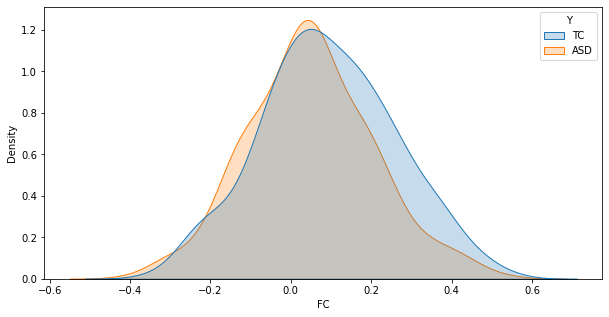

In [9]:
module1 = "Paracentral Lobule"
module2 = "Trans. Temporal G"
plot_fc_distribution(X_ABIDE, y_ABIDE, module1, module2, "ASD")

Ttest_indResult(statistic=5.539151556932735, pvalue=4.093826657768449e-08)


,TC FC,ASD FC
count,436.000000,387.000000
mean,0.272648,0.219260
std,0.145198,0.129422
min,-0.016751,-0.107950
25%,0.170421,0.137207
50%,0.243837,0.201624
75%,0.356696,0.275487
max,0.771949,0.689100


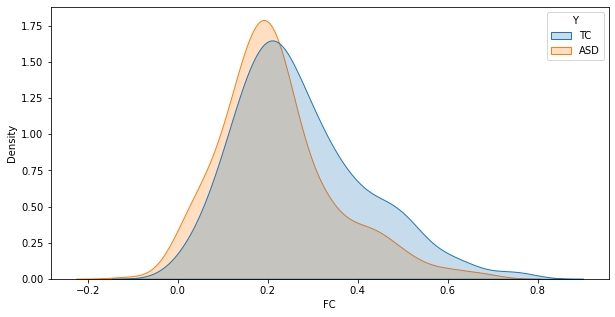

In [10]:
module1 = "Paracentral Lobule"
module2 = "Postcentral G"
plot_fc_distribution(X_ABIDE, y_ABIDE, module1, module2, "ASD")

### Site Analysis

In [11]:
ABIDE_INDIVIDUAL_df = pd.read_parquet("../../.archive/ABIDE_INDIVIDUAL/biomarkers/biomarkers.parquet")
ABIDE_INDIVIDUAL_df = ABIDE_INDIVIDUAL_df.drop(columns=["unlabeled_sites", "index"])

In [12]:
ABIDE_INDIVIDUAL_analysis_results = site_based_analysis(ABIDE_INDIVIDUAL_df)

In [13]:
ABIDE_INDIVIDUAL_analysis_results[Group(dataset="ABIDE", model_name="VAE-FFN", ssl=False, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Paracentral Lobule - Postcentral G,16,109.730260,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH...",[]
Paracentral Lobule - Trans. Temporal G,15,115.153479,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH...",[USM]
Sup. Temporal G - Thalamus,12,73.423048,"[CALTECH, LEUVEN_2, MAX_MUN, NYU, OHSU, OLIN, ...","[LEUVEN_1, STANFORD, UCLA_1, UM_1]"
Mid Occipital G - Sup. Occipital G,10,76.382770,"[CALTECH, LEUVEN_1, LEUVEN_2, OHSU, STANFORD, ...","[MAX_MUN, NYU, OLIN, PITT, UM_1, USM]"
Caudate - Paracentral Lobule,9,84.394919,"[CALTECH, MAX_MUN, NYU, OLIN, PITT, STANFORD, ...","[LEUVEN_1, LEUVEN_2, OHSU, TRINITY, UM_1, UM_2..."
...,...,...,...,...
Inf. Temporal G - Trans. Temporal G,0,8.309094,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Paracentral Lobule - Sup. Occipital G,0,8.305750,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Inf. Occipital G - Subcallosal G,0,8.119433,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Caudate - Sup. Occipital G,0,6.011878,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."


In [14]:
ABIDE_INDIVIDUAL_analysis_results[Group(dataset="ABIDE", model_name="VAECH-II", ssl=True, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Paracentral Lobule - Postcentral G,16,110.806131,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH...",[]
Paracentral Lobule - Trans. Temporal G,15,121.011266,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OL...",[OHSU]
Sup. Temporal G - Thalamus,14,76.289318,"[CALTECH, LEUVEN_2, MAX_MUN, NYU, OHSU, OLIN, ...","[LEUVEN_1, STANFORD]"
Mid Occipital G - Sup. Occipital G,11,82.102394,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, OHSU, S...","[NYU, OLIN, PITT, TRINITY, USM]"
Thalamus - Trans. Temporal G,11,70.773350,"[LEUVEN_1, LEUVEN_2, MAX_MUN, OLIN, PITT, STAN...","[CALTECH, NYU, OHSU, UM_1, UM_2]"
...,...,...,...,...
Sup. Occipital G - Thalamus,0,10.754016,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Caudate - Sup. Occipital G,0,10.080713,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Inf. Temporal G - Trans. Temporal G,0,10.076910,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Inf. Occipital G - Subcallosal G,0,9.434391,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."


In [15]:
ABIDE_INDIVIDUAL_analysis_results[Group(dataset="ABIDE", model_name="VAESDR", ssl=True, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Paracentral Lobule - Postcentral G,16,86.895232,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH...",[]
Sup. Temporal G - Thalamus,16,86.625836,"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH...",[]
Mid Temporal G - Thalamus,14,72.003921,"[CALTECH, LEUVEN_1, LEUVEN_2, NYU, OHSU, OLIN,...","[MAX_MUN, UM_1]"
Mid Occipital G - Sup. Occipital G,13,96.873848,"[LEUVEN_1, LEUVEN_2, MAX_MUN, OHSU, OLIN, PITT...","[CALTECH, NYU, UCLA_1]"
Thalamus - Trans. Temporal G,13,96.054343,"[LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OHSU, PITT,...","[CALTECH, OLIN, YALE]"
...,...,...,...,...
Sup. Occipital G - Thalamus,0,11.808047,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Caudate - Sup. Occipital G,0,11.648782,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Mid Occipital G - Sub-Gyral,0,11.380352,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."
Subcallosal G - Trans. Temporal G,0,10.916052,[],"[CALTECH, LEUVEN_1, LEUVEN_2, MAX_MUN, NYU, OH..."


# ADHD

### Whole Analysis

In [16]:
ADHD_WHOLE_df = pd.read_parquet("../../.archive/ADHD_WHOLE/biomarkers/biomarkers.parquet")
ADHD_WHOLE_df = ADHD_WHOLE_df.drop(columns=["index", "unlabeled_sites"])
ADHD_WHOLE_df

,dataset,labeled_sites,model_name,ssl,harmonize,biomarkers,module_labels
0,ADHD,"['NYU', 'PKU', 'NI', 'OHSU']",VAE-FFN,False,False,"[[2.2791221315896273, 2.222043339287873, 2.165...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
1,ADHD,"['NYU', 'PKU', 'NI', 'OHSU']",VAE-FFN,False,True,"[[2.2677217094634687, 2.522793711511227, 2.226...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
2,ADHD,"['NYU', 'PKU', 'NI', 'OHSU']",VAECH-I,False,False,"[[2.6688978077286793, 2.4778605232214392, 2.42...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
3,ADHD,"['NYU', 'PKU', 'NI', 'OHSU']",VAECH-II,False,False,"[[2.5880877089279553, 2.524906417078577, 2.390...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."
4,ADHD,"['NYU', 'PKU', 'NI', 'OHSU']",VAESDR,False,False,"[[2.5072522507126225, 2.2253698802003252, 2.29...","[Mid Frontal G, Mid Temporal G, Cingulate G, M..."


In [17]:
ADHD_WHOLE_analysis_results = whole_analysis(ADHD_WHOLE_df, significance=0.001)

In [18]:
saliency = ADHD_WHOLE_analysis_results[Group(dataset="ADHD", model_name="VAE-FFN", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Posterior Cingulate - Thalamus,7.835226,6.650817e-10,True
Inf. Frontal G - Uncus,7.523813,4.423925e-09,True
Lentiform Nucleus - Uncus,7.434816,7.471467e-09,True
Mid Occipital G - Posterior Cingulate,6.561900,8.467244e-07,True
Anterior Cingulate - Sub-Gyral,6.364107,2.231037e-06,True
Caudate - Inf. Temporal G,5.973106,1.355051e-05,True
Anterior Cingulate - Mid Frontal G,5.729676,3.867552e-05,True
Paracentral Lobule - Trans. Temporal G,5.441744,1.242743e-04,True
Inf. Frontal G - Supramarginal G,5.280399,2.309167e-04,True
Inf. Temporal G - Posterior Cingulate,5.192220,3.206103e-04,True


In [19]:
saliency = ADHD_WHOLE_analysis_results[Group(dataset="ADHD", model_name="VAECH-II", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Anterior Cingulate - Sub-Gyral,8.176217,6.811662e-11,True
Lentiform Nucleus - Uncus,7.446866,6.310666e-09,True
Extra-Nuclear - Trans. Temporal G,6.488384,1.105135e-06,True
Inf. Temporal G - Posterior Cingulate,6.452964,1.315005e-06,True
Posterior Cingulate - Thalamus,6.429725,1.472943e-06,True
Mid Occipital G - Posterior Cingulate,6.254722,3.403194e-06,True
Anterior Cingulate - Mid Frontal G,5.926423,1.512711e-05,True
Inf. Frontal G - Supramarginal G,5.404541,1.311397e-04,True
Paracentral Lobule - Trans. Temporal G,5.170383,3.178136e-04,True
Cuneus - Precuneus,4.936377,7.311392e-04,True


In [20]:
saliency = ADHD_WHOLE_analysis_results[Group(dataset="ADHD", model_name="VAESDR", ssl=False, harmonize=False)]
saliency[saliency["significance"]]

,saliency_score,p_value,significance
Lentiform Nucleus - Uncus,7.905125,5.031247e-10,True
Inf. Frontal G - Uncus,7.600120,3.261896e-09,True
Posterior Cingulate - Thalamus,7.011494,9.298780e-08,True
Anterior Cingulate - Sub-Gyral,6.916375,1.547982e-07,True
Mid Occipital G - Posterior Cingulate,6.369475,2.445415e-06,True
Anterior Cingulate - Mid Frontal G,6.104140,8.405915e-06,True
Caudate - Inf. Temporal G,5.597373,7.363425e-05,True
Inf. Temporal G - Posterior Cingulate,5.427089,1.444946e-04,True
Paracentral Lobule - Trans. Temporal G,5.354296,1.911403e-04,True
Cuneus - Precuneus,5.173564,3.746195e-04,True


Ttest_indResult(statistic=-3.520337568530431, pvalue=0.00046775852948806074)


,TC FC,ADHD FC
count,279.000000,258.000000
mean,-0.045373,-0.013846
std,0.105998,0.101131
min,-0.312903,-0.287172
25%,-0.124524,-0.079342
50%,-0.046281,-0.020401
75%,0.026416,0.053016
max,0.396425,0.289873


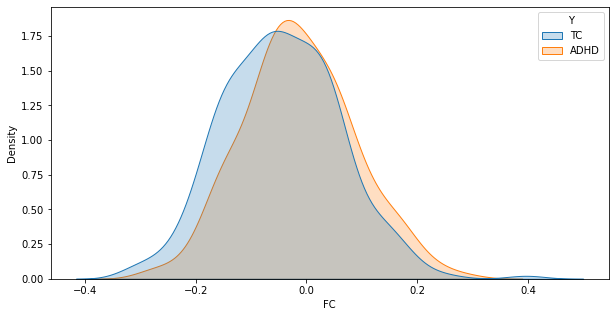

In [21]:
module1 = "Anterior Cingulate"
module2 = "Sub-Gyral"
plot_fc_distribution(X_ADHD, y_ADHD, module1, module2, "ADHD")

Ttest_indResult(statistic=-4.1756029379226005, pvalue=3.469427451818781e-05)


,TC FC,ADHD FC
count,279.000000,258.000000
mean,0.026598,0.076826
std,0.140681,0.137723
min,-0.306810,-0.286952
25%,-0.074123,-0.017311
50%,0.025025,0.060406
75%,0.107085,0.168056
max,0.460942,0.642599


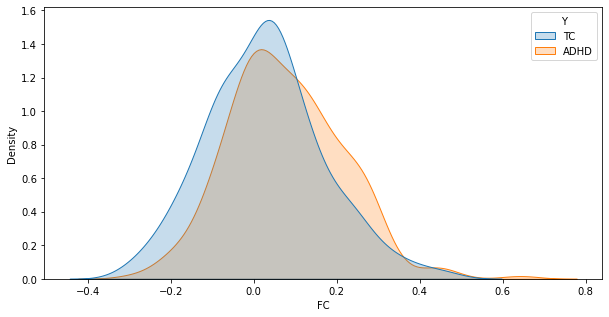

In [22]:
module1 = "Uncus"
module2 = "Lentiform Nucleus"
plot_fc_distribution(X_ADHD, y_ADHD, module1, module2, "ADHD")

Ttest_indResult(statistic=3.3229815432536616, pvalue=0.0009515193291337511)


,TC FC,ADHD FC
count,279.000000,258.000000
mean,-0.007264,-0.039047
std,0.107857,0.113764
min,-0.368744,-0.407743
25%,-0.075927,-0.110358
50%,-0.005566,-0.039916
75%,0.067367,0.036754
max,0.314489,0.372191


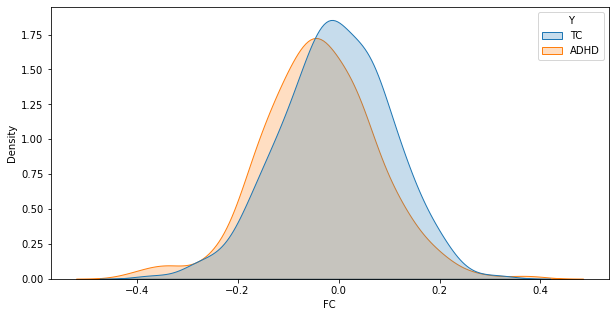

In [23]:
module1 = "Posterior Cingulate"
module2 = "Thalamus"
plot_fc_distribution(X_ADHD, y_ADHD, module1, module2, "ADHD")

### Site Analysis

In [24]:
ADHD_INDIVIDUAL_df = pd.read_parquet("../../.archive/ADHD_INDIVIDUAL/biomarkers/biomarkers.parquet")
ADHD_INDIVIDUAL_df = ADHD_INDIVIDUAL_df.drop(columns=["index", "unlabeled_sites"])

In [25]:
ADHD_INDIVIDUAL_analysis_results = site_based_analysis(ADHD_INDIVIDUAL_df)

In [26]:
ADHD_INDIVIDUAL_analysis_results[Group(dataset="ADHD", model_name="VAE-FFN", ssl=False, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Thalamus - Trans. Temporal G,4,25.970531,"[NI, NYU, OHSU, PKU]",[]
Inf. Occipital G - Sup. Occipital G,4,25.717534,"[NI, NYU, OHSU, PKU]",[]
Anterior Cingulate - Mid Frontal G,4,21.129717,"[NI, NYU, OHSU, PKU]",[]
Inf. Frontal G - Supramarginal G,4,17.449428,"[NI, NYU, OHSU, PKU]",[]
Lentiform Nucleus - Uncus,3,23.455905,"[NI, OHSU, PKU]",[NYU]
...,...,...,...,...
Sup. Parietal Lobule - Uncus,0,2.155725,[],"[NI, NYU, OHSU, PKU]"
Sup. Occipital G - Uncus,0,2.080899,[],"[NI, NYU, OHSU, PKU]"
Supramarginal G - Trans. Temporal G,0,1.470267,[],"[NI, NYU, OHSU, PKU]"
Inf. Occipital G - Uncus,0,1.452822,[],"[NI, NYU, OHSU, PKU]"


In [27]:
ADHD_INDIVIDUAL_analysis_results[Group(dataset="ADHD", model_name="VAECH-II", ssl=True, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Thalamus - Trans. Temporal G,4,29.329817,"[NI, NYU, OHSU, PKU]",[]
Lentiform Nucleus - Uncus,4,23.753205,"[NI, NYU, OHSU, PKU]",[]
Anterior Cingulate - Mid Frontal G,4,19.992378,"[NI, NYU, OHSU, PKU]",[]
Inf. Occipital G - Posterior Cingulate,4,17.926671,"[NI, NYU, OHSU, PKU]",[]
Inf. Occipital G - Sup. Occipital G,3,21.430314,"[NYU, OHSU, PKU]",[NI]
...,...,...,...,...
Sup. Parietal Lobule - Uncus,0,2.646379,[],"[NI, NYU, OHSU, PKU]"
Sub-Gyral - Uncus,0,2.566098,[],"[NI, NYU, OHSU, PKU]"
Caudate - Sup. Occipital G,0,2.206993,[],"[NI, NYU, OHSU, PKU]"
Trans. Temporal G - Uncus,0,1.586603,[],"[NI, NYU, OHSU, PKU]"


In [28]:
ADHD_INDIVIDUAL_analysis_results[Group(dataset="ADHD", model_name="VAESDR", ssl=True, harmonize=False)]

,site_present_rate,saliency_score,sites_present,sites_absent
Lentiform Nucleus - Uncus,4,22.631609,"[NI, NYU, OHSU, PKU]",[]
Anterior Cingulate - Mid Frontal G,4,20.481698,"[NI, NYU, OHSU, PKU]",[]
Mid Occipital G - Sup. Occipital G,4,19.521025,"[NI, NYU, OHSU, PKU]",[]
Anterior Cingulate - Sub-Gyral,3,30.833956,"[NI, OHSU, PKU]",[NYU]
Thalamus - Trans. Temporal G,3,30.111634,"[NYU, OHSU, PKU]",[NI]
...,...,...,...,...
Inf. Occipital G - Mid Occipital G,0,2.360377,[],"[NI, NYU, OHSU, PKU]"
Caudate - Sup. Occipital G,0,2.322788,[],"[NI, NYU, OHSU, PKU]"
Supramarginal G - Trans. Temporal G,0,1.782329,[],"[NI, NYU, OHSU, PKU]"
Inf. Occipital G - Uncus,0,1.572457,[],"[NI, NYU, OHSU, PKU]"
